In [8]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

In [9]:
def linear_kernel(x1,x2):
    return np.dot(x1,x2)

def polynomial_kernel(x,y, p=3):
    return ((1+ np.dot(x,y)) **p)

def gaussian_kernel(x,y,sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2*(sigma**2)))

     pcost       dcost       gap    pres   dres
 0:  1.4359e+05 -9.5981e+07  2e+08  6e-01  4e-12
 1:  4.2157e+05 -1.8490e+07  3e+07  4e-02  1e-11
 2:  2.6444e+05 -3.0753e+06  4e+06  5e-03  4e-12
 3:  1.9717e+04 -4.9044e+05  5e+05  2e-04  2e-12
 4: -7.5587e+03 -6.2571e+04  6e+04  2e-05  2e-12
 5: -9.0395e+03 -6.2869e+04  5e+04  2e-05  2e-12
 6: -8.3377e+03 -5.5483e+04  5e+04  9e-06  2e-12
 7: -1.0004e+04 -4.1184e+04  3e+04  5e-06  2e-12
 8: -1.0861e+04 -2.2514e+04  1e+04  1e-06  2e-12
 9: -1.1403e+04 -2.1297e+04  1e+04  9e-07  2e-12
10: -1.1640e+04 -1.8813e+04  7e+03  5e-07  2e-12
11: -1.3108e+04 -1.5533e+04  2e+03  1e-08  3e-12
12: -1.3150e+04 -1.5277e+04  2e+03  9e-09  3e-12
13: -1.3468e+04 -1.4685e+04  1e+03  2e-09  4e-12
14: -1.3831e+04 -1.4121e+04  3e+02  8e-11  4e-12
15: -1.3962e+04 -1.3974e+04  1e+01  1e-11  3e-12
16: -1.3967e+04 -1.3968e+04  3e-01  4e-12  4e-12
17: -1.3968e+04 -1.3968e+04  3e-03  6e-12  3e-12
Optimal solution found.
21 support vectors out of 180 points
20 out of

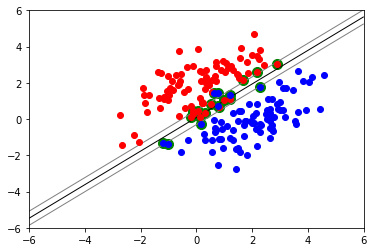

In [10]:
# Mathieu Blondel, September 2010
# License: BSD 3 clause
# http://www.mblondel.org/journal/2010/09/19/support-vector-machines-in-python/

# visualizing what translating to another dimension does
# and bringing back to 2D:
# https://www.youtube.com/watch?v=3liCbRZPrZA

# Docs: http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# Docs qp example: http://cvxopt.org/examples/tutorial/qp.html

# Nice tutorial:
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf


import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

        
    #test_linear()
    #test_non_linear()
    test_soft() #softmargin

     pcost       dcost       gap    pres   dres
 0: -3.5752e+01 -8.4617e+01  1e+03  4e+01  2e+00
 1: -7.0264e+01 -8.6496e+01  7e+02  2e+01  1e+00
 2: -3.4395e+01 -1.4598e+01  2e+02  6e+00  4e-01
 3: -2.5826e+00 -5.9638e-01  2e+01  4e-01  3e-02
 4: -2.6107e-01 -4.6000e-01  3e+00  6e-02  4e-03
 5: -2.0030e-01 -4.5596e-01  2e+00  4e-02  2e-03
 6: -1.0564e-01 -2.8577e-01  5e-01  8e-03  5e-04
 7: -1.1755e-01 -2.1349e-01  2e-01  2e-03  2e-04
 8: -1.4161e-01 -2.0459e-01  1e-01  1e-03  8e-05
 9: -1.5795e-01 -1.9366e-01  7e-02  6e-04  4e-05
10: -1.7506e-01 -1.8720e-01  1e-02  4e-16  2e-14
11: -1.8475e-01 -1.8562e-01  9e-04  3e-16  2e-14
12: -1.8548e-01 -1.8549e-01  1e-05  3e-16  2e-14
13: -1.8549e-01 -1.8549e-01  1e-07  1e-16  2e-14
Optimal solution found.
8 support vectors out of 180 points
20 out of 20 predictions correct


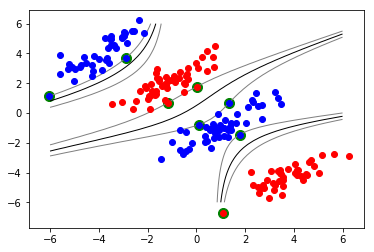

In [11]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0: -1.4484e+01 -2.5845e+01  5e+02  2e+01  2e+00
 1: -1.1310e+01 -4.5585e+00  6e+01  3e+00  2e-01
 2: -3.9487e+00 -2.4087e+00  4e+00  2e-01  2e-02
 3: -2.1644e+00 -2.2460e+00  4e-01  1e-02  8e-04
 4: -2.2002e+00 -2.2265e+00  4e-02  5e-04  4e-05
 5: -2.2203e+00 -2.2233e+00  4e-03  5e-05  4e-06
 6: -2.2231e+00 -2.2232e+00  5e-05  6e-07  4e-08
 7: -2.2232e+00 -2.2232e+00  5e-07  6e-09  4e-10
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


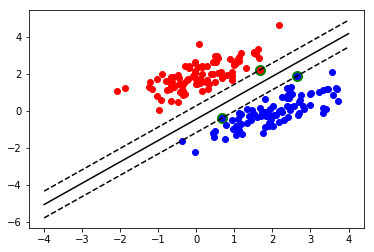

In [12]:
test_linear()

In [ ]:
#probability: confidence -- "scores and probabilities"
#tolerance: check to see if  both sides (margin kiri kanan) have a value either .001
# if both side have a value of that or less (0.001) it's going say: "yep we found our optimum number"
# you can change the value of param if you want to get more optimize. you could make that rather than 3/8.
#maxiter, either 
#decision funct shape: one versus rest/ one versus one (recommend ovr)